In [1]:
import fastbook
fastbook.setup_book()
from fastbook import *

from fastai.tabular.all import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from dtreeviz.trees import *

# Chapter 8: tabular models

In [2]:
path = Path('data/bulldozer')

In [2]:
df = pd.read_csv(path/'TrainAndValid.csv')
df.head()

NameError: name 'path' is not defined

## Features

In [5]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

### Ordering

Some categorical features have a natural ordering:

In [7]:
df.ProductSize.unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [8]:
sizes = ['Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']
df.ProductSize = df.ProductSize.astype('category')
df.ProductSize.cat.set_categories(sizes, ordered=True, inplace=True)

### Dates

fastai has a generic method that extracts lots of categorical information about a numerical date.

In [10]:
df = add_datepart(df, 'saledate')

In [11]:
[c for c in df.columns if c.startswith('sale')]

['saleWeek',
 'saleYear',
 'saleMonth',
 'saleDay',
 'saleDayofweek',
 'saleDayofyear',
 'saleIs_month_end',
 'saleIs_month_start',
 'saleIs_quarter_end',
 'saleIs_quarter_start',
 'saleIs_year_end',
 'saleIs_year_start',
 'saleElapsed']

### Further preprocessing

For cleanup:

In [13]:
procs = [Categorify, FillMissing]

For a sensible split into the validation set:

In [16]:
condition = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where(condition)[0]
valid_idx = np.where(~condition)[0]

splits = (list(train_idx), list(valid_idx))

This kaggle competition says the metric should be RLMSE. We can achieve that by taking the log of the dependent variable now and later use the standard RMSE.

In [9]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

Lastly, the categories:

In [ ]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

### DataLoader

In [17]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [18]:
len(to.train), len(to.valid)

(404710, 7988)

In [19]:
to.show(3)

,saleWeek,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,46,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1163635200,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,16,3,320,11.097410
1,13,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1080259200,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,26,4,86,10.950807
2,9,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,1077753600,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,26,3,57,9.210340


In [20]:
to.items.head(3)

,SalesID,SalePrice,MachineID,saleWeek,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,46,3157,121,3.0,2004,68.0,2,...,320,1,1,1,1,1,1,2647,1,1
1,1139248,10.950807,117657,13,77,121,3.0,1996,4640.0,2,...,86,1,1,1,1,1,1,2148,1,1
2,1139249,9.210340,434808,9,7009,121,3.0,2001,2838.0,1,...,57,1,1,1,1,1,1,2131,1,1


In [24]:
pickle.dump(to, (path/'to.pkl').open('wb'))

# Decision tree

In [3]:
to = pickle.load((path/'to.pkl').open('rb'))
to.show(3)

,saleWeek,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,46,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1163635200,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,16,3,320,11.097410
1,13,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1080259200,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,26,4,86,10.950807
2,9,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,1077753600,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,26,3,57,9.210340


In [4]:
xs = to.train.xs
y = to.train.y

valid_xs = to.valid.xs
valid_y = to.valid.y

In [5]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

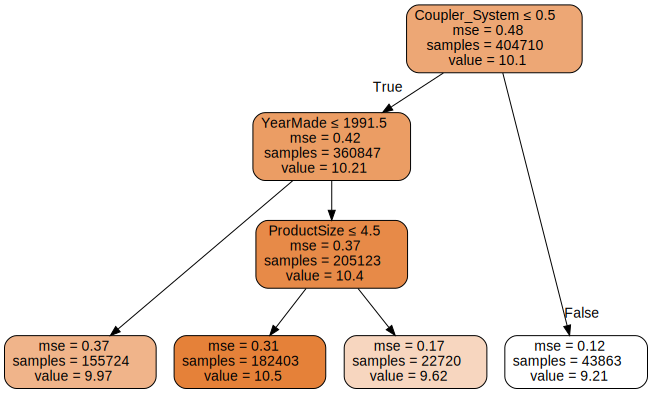

In [8]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

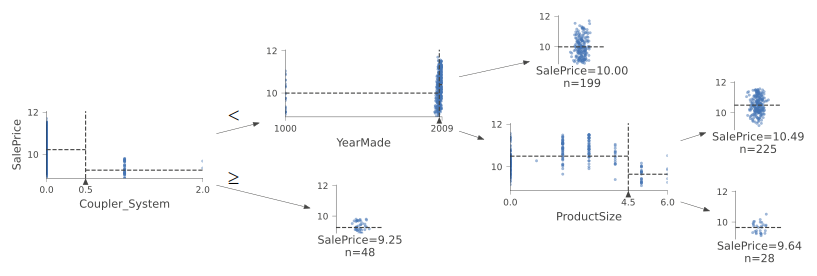

In [13]:
samp_idx = np.random.permutation(len(y))[:500]
dep_var = 'SalePrice'
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var, fontname='DejaVu Sans', scale=1.5, orientation='LR', label_fontsize=10)

A YearMade of 1000 is probably the way to mark missing values in this dataset. Let's replace it with 1950 to make visualization easier.

In [14]:
xs.loc[xs.YearMade<1950, 'YearMade'] = 1950
valid_xs.loc[valid_xs.YearMade<1950, 'YearMade'] = 1950

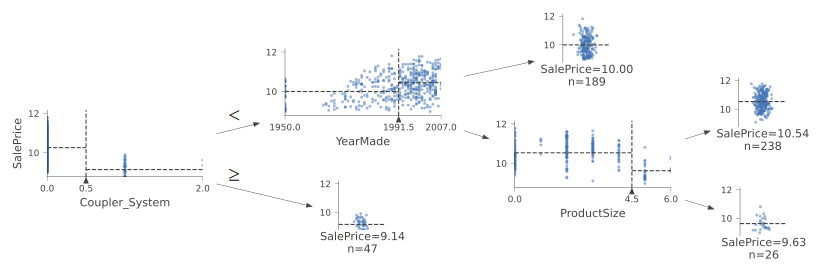

In [15]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)
samp_idx = np.random.permutation(len(y))[:500]
dep_var = 'SalePrice'
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var, fontname='DejaVu Sans', scale=1.5, orientation='LR', label_fontsize=10)

In [27]:
def r_mse(pred, y): return np.round(np.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [29]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.55325, 0.55646)

In [30]:
m = DecisionTreeRegressor().fit(xs, y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.0, 0.333181)

In [32]:
m = DecisionTreeRegressor(min_samples_leaf=25).fit(xs, y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.211701, 0.268534)

# Random Forest

In [36]:
def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples, max_features=max_features,
                                min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [37]:
m = rf(xs, y)

In [38]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.171203, 0.234165)

In [42]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
r_mse(preds.mean(0), valid_y)

0.234165

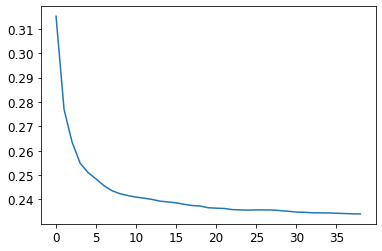

In [46]:
plt.plot([r_mse(preds[:i].mean(0), valid_y) for i in range(1,40)]);

## OOB score

In [47]:
r_mse(m.oob_prediction_, y)

0.211092

# Model interpretation